# ICU Length of Stay Prediction Using Time-Series Deep Learning (LSTM)
### Data Loading, Cleaning, and Sequence Generation for 24 hr window

In [40]:
# ===============================================
# ICU LOS Classification – Time-Series (LSTM)
# ===============================================

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

# ------------------------------
# 1. Load and sort data
# ------------------------------
df = pd.read_csv("icu_los_features_classification_lstm.csv")
df = df.sort_values(by=["stay_id", "hour_index"]).reset_index(drop=True)

# Create los_category: 0 = Short (<=3 days), 1 = Long (>3 days)
df['los_category'] = df['icu_los_days'].apply(lambda x: 0 if x <= 3 else 1)

# ------------------------------
# 2. Define feature + target columns
# ------------------------------
feature_col=["heart_rate", "bp_systolic", "bp_diastolic", "spo2", "resp_rate", 
 "temperature", "platelets", "creatinine", "glucose", "hemoglobin"]
target_col = "los_category"  # 0 = Short stay, 1 = Long stay

# ------------------------------
# 3. Handle missing values (time-based imputation)
# ------------------------------
df[feature_cols] = df.groupby("stay_id")[feature_cols].ffill().bfill()
df[feature_cols] = df[feature_cols].fillna(df[feature_cols].median())



# ------------------------------
# 4. C4. Create sequences per stay_id to consider first 24 hrs for prediction
# ------------------------------
seq_len = 24
X_sequences = []
y_labels = []

for stay_id, group in df.groupby("stay_id"):
    values = group[feature_cols].values
    if len(values) >= seq_len:
        seq = values[:seq_len]  
    else:
        pad_len = seq_len - len(values)
        seq = np.vstack([np.zeros((pad_len, len(feature_cols))), values])
    
    X_sequences.append(seq)
    y_labels.append(group[target_col].iloc[0])

X = np.array(X_sequences)
y = np.array(y_labels)

print(f"Final shape of X: {X.shape}  (samples, timesteps, features)")
print(f"Class balance: {np.bincount(y)}")

# ------------------------------
# 5. Feature scaling (safe z-score normalization)
# ------------------------------
num_samples, num_timesteps, num_features = X.shape
X_reshaped = X.reshape(-1, num_features)

scaler = StandardScaler()

# Identify zero-variance columns
stds = X_reshaped.std(axis=0)
zero_var_cols = np.where(stds == 0)[0]

# Temporarily set zero-variance columns to 0 to avoid divide-by-zero
X_reshaped[:, zero_var_cols] = 0.0
scaler.fit(X_reshaped)
X_scaled = scaler.transform(X_reshaped)

# Replace any NaN or inf with zeros
X_scaled = np.nan_to_num(X_scaled, nan=0.0, posinf=0.0, neginf=0.0)

# Reshape back to (samples, timesteps, features)
X = X_scaled.reshape(num_samples, num_timesteps, num_features)

# ------------------------------
# 6. Train-test split
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ------------------------------
# 7. Convert to PyTorch tensors
# ------------------------------
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Split validation set
val_ratio = 0.2
val_size = int(len(train_dataset) * val_ratio)
train_size = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("Data preprocessing complete! Loaders ready for LSTM training.")

Final shape of X: (90504, 24, 9)  (samples, timesteps, features)
Class balance: [59445 31059]
Data preprocessing complete! Loaders ready for LSTM training.


### Model Architecture Definition for 24-hr window

In [9]:
import torch
import torch.nn as nn
from torchinfo import summary

# Example LSTM model
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, output_size=2, dropout=0.3):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.relu(out[:, -1, :])
        out = self.fc(out)
        return out

input_size = len(feature_cols)
model = LSTMClassifier(input_size)

In [16]:
# Print PyTorch model summary
summary(model, input_size=(64, 24, input_size), device="cpu")

Layer (type:depth-idx)                   Output Shape              Param #
LSTMClassifier                           [64, 2]                   --
├─LSTM: 1-1                              [64, 24, 128]             203,264
├─ReLU: 1-2                              [64, 128]                 --
├─Linear: 1-3                            [64, 2]                   258
Total params: 203,522
Trainable params: 203,522
Non-trainable params: 0
Total mult-adds (M): 312.23
Input size (MB): 0.06
Forward/backward pass size (MB): 1.57
Params size (MB): 0.81
Estimated Total Size (MB): 2.44

## Model Training, Optimization, and Performance Evaluation

Epoch 1/40 | Train Loss: 0.5800 | Val Loss: 0.5692
Epoch 2/40 | Train Loss: 0.5690 | Val Loss: 0.5643
Epoch 3/40 | Train Loss: 0.5655 | Val Loss: 0.5673
Epoch 4/40 | Train Loss: 0.5740 | Val Loss: 0.5738
Epoch 5/40 | Train Loss: 0.5642 | Val Loss: 0.5613
Epoch 6/40 | Train Loss: 0.5625 | Val Loss: 0.5603
Epoch 7/40 | Train Loss: 0.5619 | Val Loss: 0.5602
Epoch 8/40 | Train Loss: 0.5611 | Val Loss: 0.5600
Epoch 9/40 | Train Loss: 0.5602 | Val Loss: 0.5591
Epoch 10/40 | Train Loss: 0.5591 | Val Loss: 0.5577
Epoch 11/40 | Train Loss: 0.5584 | Val Loss: 0.5563
Epoch 12/40 | Train Loss: 0.5568 | Val Loss: 0.5563
Epoch 13/40 | Train Loss: 0.5556 | Val Loss: 0.5544
Epoch 14/40 | Train Loss: 0.5542 | Val Loss: 0.5560
Epoch 15/40 | Train Loss: 0.5532 | Val Loss: 0.5548
Epoch 16/40 | Train Loss: 0.5528 | Val Loss: 0.5543
Epoch 17/40 | Train Loss: 0.5517 | Val Loss: 0.5543
Epoch 18/40 | Train Loss: 0.5526 | Val Loss: 0.5548
Epoch 19/40 | Train Loss: 0.5502 | Val Loss: 0.5524
Epoch 20/40 | Train L

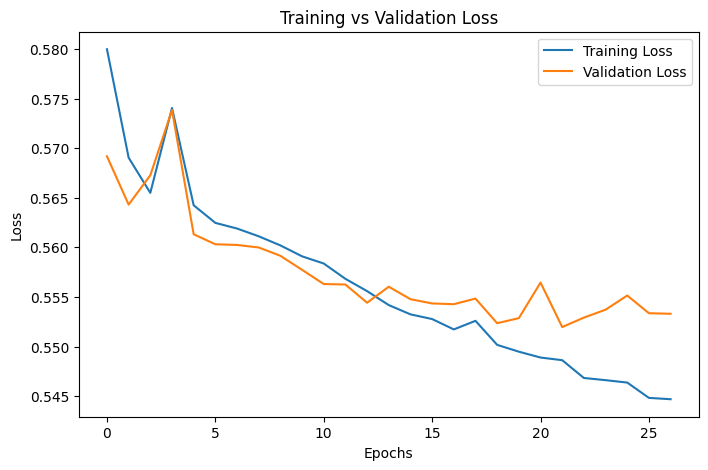

In [36]:
# ------------------------------
# 9. Loss, optimizer, early stopping
# ------------------------------
# Compute class weights
class_counts = np.bincount(y_train)
class_weights = torch.tensor([class_counts[1]/sum(class_counts), class_counts[0]/sum(class_counts)], dtype=torch.float32)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 40
patience = 5
best_val_loss = float("inf")
patience_counter = 0
train_losses, val_losses = [], []

# ------------------------------
# 10. Training loop
# ------------------------------
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    
    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# ------------------------------
# 11. Evaluation on test set
# ------------------------------
model.eval()
y_pred = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1).numpy()
        y_pred.extend(preds)

y_true = y_test
y_pred = np.array(y_pred)

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"\nTest Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred))

# ------------------------------
# 12. Plot loss
# ------------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

## Model Evaluation and Performance Visualization for 24-hr window

Confusion Matrix:
 [[6566 5323]
 [1302 4910]]

Classification Report:
               precision    recall  f1-score   support

  Short Stay       0.83      0.55      0.66     11889
   Long Stay       0.48      0.79      0.60      6212

    accuracy                           0.63     18101
   macro avg       0.66      0.67      0.63     18101
weighted avg       0.71      0.63      0.64     18101



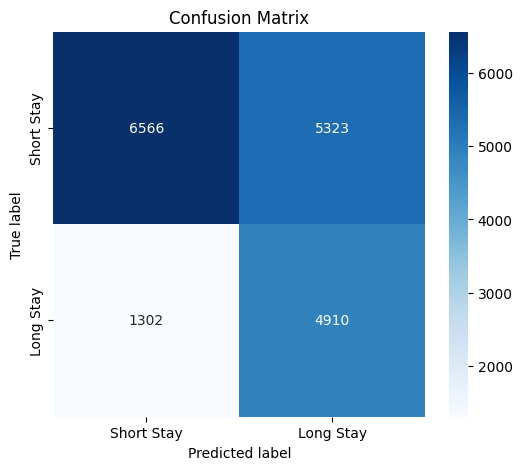

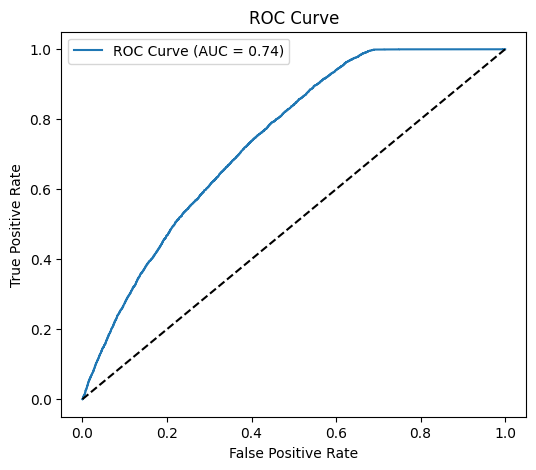

In [37]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# ------------------------------
# Get predictions from LSTM model
# ------------------------------
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, y_pred = torch.max(outputs, 1)
    y_pred = y_pred.numpy()
    y_probs = torch.softmax(outputs, dim=1)[:, 1].numpy()  # probability for class 1 (Long Stay)

# ------------------------------
# Confusion Matrix
# ------------------------------
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["Short Stay", "Long Stay"]))

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Short Stay','Long Stay'], 
            yticklabels=['Short Stay','Long Stay'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

# ------------------------------
# ROC Curve
# ------------------------------
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### Sequence Generation for 48 hr window

In [38]:
# ------------------------------
# 4. Create sequences per stay_id to consider first 48 hrs prediction
# ------------------------------
seq_len = 48
X_sequences = []
y_labels = []

for stay_id, group in df.groupby("stay_id"):
    values = group[feature_cols].values
    if len(values) >= seq_len:
        seq = values[:seq_len]  
    else:
        pad_len = seq_len - len(values)
        seq = np.vstack([np.zeros((pad_len, len(feature_cols))), values])
    
    X_sequences.append(seq)
    y_labels.append(group[target_col].iloc[0])

X = np.array(X_sequences)
y = np.array(y_labels)

print(f"Final shape of X: {X.shape}  (samples, timesteps, features)")
print(f"Class balance: {np.bincount(y)}")

# ------------------------------
# 5. Feature scaling (safe z-score normalization)
# ------------------------------
num_samples, num_timesteps, num_features = X.shape
X_reshaped = X.reshape(-1, num_features)

scaler = StandardScaler()

# Identify zero-variance columns
stds = X_reshaped.std(axis=0)
zero_var_cols = np.where(stds == 0)[0]

# Temporarily set zero-variance columns to 0 to avoid divide-by-zero
X_reshaped[:, zero_var_cols] = 0.0
scaler.fit(X_reshaped)
X_scaled = scaler.transform(X_reshaped)

# Replace any NaN or inf with zeros
X_scaled = np.nan_to_num(X_scaled, nan=0.0, posinf=0.0, neginf=0.0)

# Reshape back to (samples, timesteps, features)
X = X_scaled.reshape(num_samples, num_timesteps, num_features)

# ------------------------------
# 6. Train-test split
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ------------------------------
# 7. Convert to PyTorch tensors
# ------------------------------
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Split validation set
val_ratio = 0.2
val_size = int(len(train_dataset) * val_ratio)
train_size = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("Data preprocessing complete! Loaders ready for LSTM training.")

Final shape of X: (90504, 48, 9)  (samples, timesteps, features)
Class balance: [59445 31059]
Data preprocessing complete! Loaders ready for LSTM training.


### Model Architecture Definition for 48 hr window

In [14]:
# ------------------------------
# 8. Define LSTM model
# ------------------------------
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, output_size=2, dropout=0.3):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.relu(out[:, -1, :])  # last timestep
        out = self.fc(out)
        return out

input_size = len(feature_cols)
model = LSTMClassifier(input_size)

In [18]:
summary(model, input_size=(64, 48, input_size), device="cpu")

Layer (type:depth-idx)                   Output Shape              Param #
LSTMClassifier                           [64, 2]                   --
├─LSTM: 1-1                              [64, 48, 128]             203,264
├─ReLU: 1-2                              [64, 128]                 --
├─Linear: 1-3                            [64, 2]                   258
Total params: 203,522
Trainable params: 203,522
Non-trainable params: 0
Total mult-adds (M): 624.44
Input size (MB): 0.11
Forward/backward pass size (MB): 3.15
Params size (MB): 0.81
Estimated Total Size (MB): 4.07

## Model Training, Optimization, and Performance Evaluation for 48 hr window

Epoch 1/40 | Train Loss: 0.3403 | Val Loss: 0.3151
Epoch 2/40 | Train Loss: 0.3144 | Val Loss: 0.3231
Epoch 3/40 | Train Loss: 0.3098 | Val Loss: 0.3000
Epoch 4/40 | Train Loss: 0.3040 | Val Loss: 0.3024
Epoch 5/40 | Train Loss: 0.3024 | Val Loss: 0.3010
Epoch 6/40 | Train Loss: 0.3017 | Val Loss: 0.2985
Epoch 7/40 | Train Loss: 0.3015 | Val Loss: 0.2986
Epoch 8/40 | Train Loss: 0.3008 | Val Loss: 0.2977
Epoch 9/40 | Train Loss: 0.3005 | Val Loss: 0.2971
Epoch 10/40 | Train Loss: 0.3000 | Val Loss: 0.2959
Epoch 11/40 | Train Loss: 0.2994 | Val Loss: 0.2954
Epoch 12/40 | Train Loss: 0.2984 | Val Loss: 0.2951
Epoch 13/40 | Train Loss: 0.2982 | Val Loss: 0.2957
Epoch 14/40 | Train Loss: 0.3130 | Val Loss: 0.2994
Epoch 15/40 | Train Loss: 0.3020 | Val Loss: 0.3006
Epoch 16/40 | Train Loss: 0.3026 | Val Loss: 0.2990
Epoch 17/40 | Train Loss: 0.3026 | Val Loss: 0.2991
Early stopping triggered.

Test Accuracy: 0.8532
Precision: 0.7017
Recall: 0.9955
F1-score: 0.8232

Confusion Matrix:
 [[9260

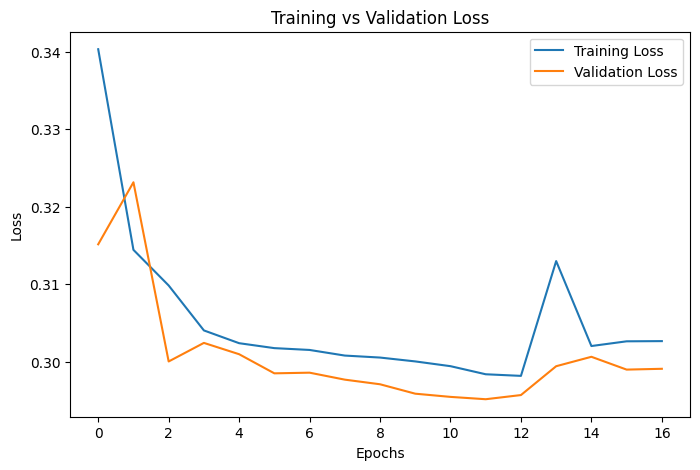

In [32]:

# ------------------------------
# 9. Loss, optimizer, early stopping
# ------------------------------
# Compute class weights
class_counts = np.bincount(y_train)
class_weights = torch.tensor([class_counts[1]/sum(class_counts), class_counts[0]/sum(class_counts)], dtype=torch.float32)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 40
patience = 5
best_val_loss = float("inf")
patience_counter = 0
train_losses, val_losses = [], []

# ------------------------------
# 10. Training loop
# ------------------------------
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    
    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# ------------------------------
# 11. Evaluation on test set
# ------------------------------
model.eval()
y_pred = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1).numpy()
        y_pred.extend(preds)

y_true = y_test
y_pred = np.array(y_pred)

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"\nTest Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred))

# ------------------------------
# 12. Plot loss
# ------------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

### Model Evaluation and Performance Visualization for 48 hr window

Confusion Matrix:
 [[9260 2629]
 [  28 6184]]

Classification Report:
               precision    recall  f1-score   support

  Short Stay       1.00      0.78      0.87     11889
   Long Stay       0.70      1.00      0.82      6212

    accuracy                           0.85     18101
   macro avg       0.85      0.89      0.85     18101
weighted avg       0.90      0.85      0.86     18101



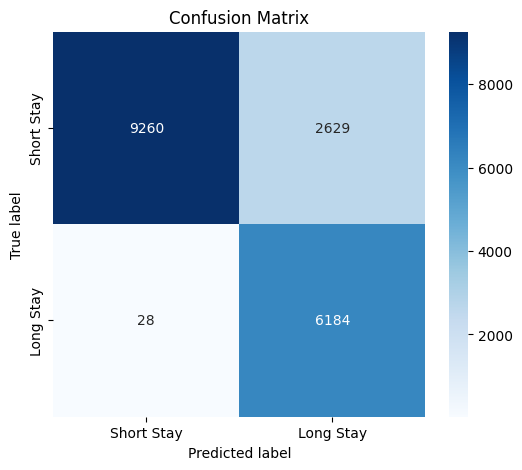

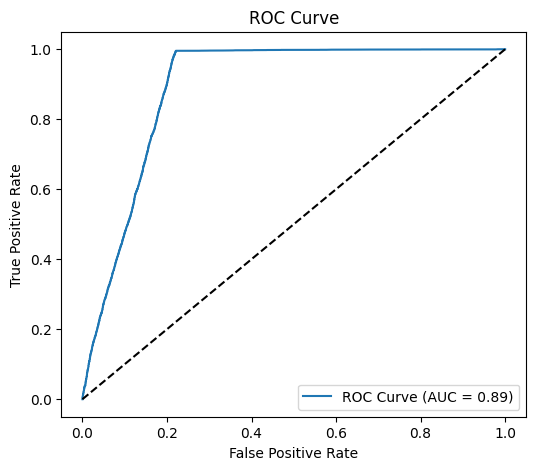

In [33]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# ------------------------------
# Get predictions from LSTM model
# ------------------------------
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, y_pred = torch.max(outputs, 1)
    y_pred = y_pred.numpy()
    y_probs = torch.softmax(outputs, dim=1)[:, 1].numpy()  # probability for class 1 (Long Stay)

# ------------------------------
# Confusion Matrix
# ------------------------------
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["Short Stay", "Long Stay"]))

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Short Stay','Long Stay'], 
            yticklabels=['Short Stay','Long Stay'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

# ------------------------------
# ROC Curve
# ------------------------------
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Epoch 1/40 | Train Loss: 0.3189 | Val Loss: 0.3040
Epoch 2/40 | Train Loss: 0.3077 | Val Loss: 0.3146
Epoch 3/40 | Train Loss: 0.3622 | Val Loss: 0.3018
Epoch 4/40 | Train Loss: 0.3024 | Val Loss: 0.3014
Epoch 5/40 | Train Loss: 0.3016 | Val Loss: 0.3013
Epoch 6/40 | Train Loss: 0.3012 | Val Loss: 0.3011
Epoch 7/40 | Train Loss: 0.3014 | Val Loss: 0.3010
Epoch 8/40 | Train Loss: 0.3020 | Val Loss: 0.2998
Epoch 9/40 | Train Loss: 0.3006 | Val Loss: 0.2999
Epoch 10/40 | Train Loss: 0.3003 | Val Loss: 0.3015
Epoch 11/40 | Train Loss: 0.3002 | Val Loss: 0.2991
Epoch 12/40 | Train Loss: 0.3006 | Val Loss: 0.2998
Epoch 13/40 | Train Loss: 0.3011 | Val Loss: 0.2999
Epoch 14/40 | Train Loss: 0.3006 | Val Loss: 0.3012
Epoch 15/40 | Train Loss: 0.3018 | Val Loss: 0.3016
Epoch 16/40 | Train Loss: 0.3022 | Val Loss: 0.3012
Early stopping triggered.

Test Accuracy: 0.8531
Precision: 0.7015
Recall: 0.9955
F1-score: 0.8231

Confusion Matrix:
 [[9258 2631]
 [  28 6184]]

Classification Report:
       

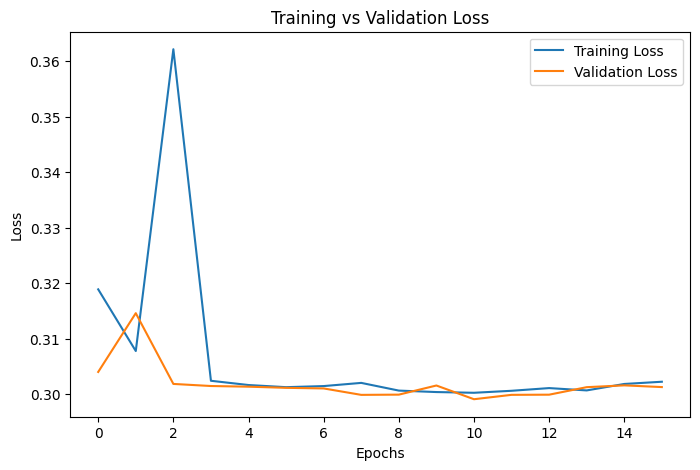

In [50]:

# ------------------------------
# 9. Loss, optimizer, early stopping
# ------------------------------
# Compute class weights
class_counts = np.bincount(y_train)
class_weights = torch.tensor([class_counts[1]/sum(class_counts), class_counts[0]/sum(class_counts)], dtype=torch.float32)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 40
patience = 5
best_val_loss = float("inf")
patience_counter = 0
train_losses, val_losses = [], []

# ------------------------------
# 10. Training loop
# ------------------------------
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    
    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# ------------------------------
# 11. Evaluation on test set
# ------------------------------
model.eval()
y_pred = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1).numpy()
        y_pred.extend(preds)

y_true = y_test
y_pred = np.array(y_pred)

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"\nTest Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred))

# ------------------------------
# 12. Plot loss
# ------------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()